# Avazu Click-Through-Rate Dataset

For more information about this Kaggle problem, click [here](http://www.kaggle.com/c/avazu-ctr-prediction/) to see more details.

### Feature Set

* **id**: ad identifier
* **click**: 0/1 for non-click/click
* **hour**: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* **C1**: anonymized categorical variable
* **banner_pos**
* **site_id**
* **site_domain**
* **site_category**
* **app_id**
* **app_domain**
* **app_category**
* **device_id**
* **device_ip**
* **device_model**
* **device_type**
* **device_conn_type**
* **C14-C21**: anonymized categorical variables


The variables are all categorical, we need to take this into account to our analysis.

Principal conclusion from the analysis: There are certain features which have lots of levels. There might be an issue here in terms of the Curse of the Dimensionality, because using OneHotEncoder to transform these features to binary features will increase significantly the number of features.

In [147]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv",nrows=1000000)
feature_set = train.columns.values.tolist()

for f in feature_set:
    train[f] = train[f].astype('category') # Convert each feature to categorical. Converting all in once would throw an error

train.describe()[feature_set[:11]]

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,2,6,7,7,2075,2030,21,2309,156,23
top,9999995711060789250,0,14102104,1005,0,85f751fd,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22
freq,1,839781,264711,935852,777714,332893,348412,360056,667107,707429,679869


In [2]:
train.describe()[feature_set[11:]]

,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,83431,313002,4581,4,4,606,8,9,162,4,41,161,35
top,a99f214a,6b9769f2,8a4875bd,1,0,21611,320,50,1722,0,35,-1,79
freq,840265,5886,59771,950293,895464,83055,953430,957006,256389,425079,487516,545390,256389


### Relating each feature individually with the clicks

As it is possible to verify, from the 1M rows read, about 16% of the sample ads were clicked. However, there might be some levels within a feature that increase or decrease the probability of getting an ad clicked.

The following plot address these cases. Imagine the following: "device_conn_type" address the type of connection used by the user. What if a particular connection type encourages the user to click in an ad? This is a possible question that I'm trying to answer with a bar plot.

In [277]:
%matplotlib inline
import matplotlib.patches as mpatches

counts = train['click'].value_counts()
prob = train['click'].value_counts()[1]/train['click'].value_counts().sum(axis=0)

print("Prior probability of getting an ad clicked: " + str(prob))
def conditional_clicks(feature,click_prob):
    sample = train[[feature,'click']]
    group = sample.groupby([feature])

    new_df = pd.DataFrame({'0':group.count()['click']-group.sum()['click'],'1':group.sum()['click']}, columns=['0','1'])
    print(new_df)
    
    _sum = new_df.sum(axis=1)
    for c in new_df.columns.values:
        new_df[c] = new_df[c]/_sum
    

    ax = new_df.plot(kind='bar',fontsize=20,figsize=(34, 10),title="Feature " + "\""+feature+"\" influence over the click probability")
    ax.set_title(ax.get_title(), fontsize=30)
    ax.set_xlabel(feature, fontsize=20)
    ax.set_ylabel("Probability", fontsize=20)
    
    y = np.empty(101)
    y.fill(click_prob)

    clicked_patch = mpatches.Patch(color='green', label='Ad clicked')
    notclicked_patch = mpatches.Patch(color='blue', label='Ad not clicked')
    
    plt.legend(handles=[notclicked_patch,clicked_patch],prop={'size':26})
    
    ax.plot(range(-1,100),y,'g',lw=2.5)

Prior probability of getting an ad clicked: 0.160219


                       0       1
device_conn_type                
0                 747014  148450
2                  81263   10782
3                  10637     954
5                    867      33


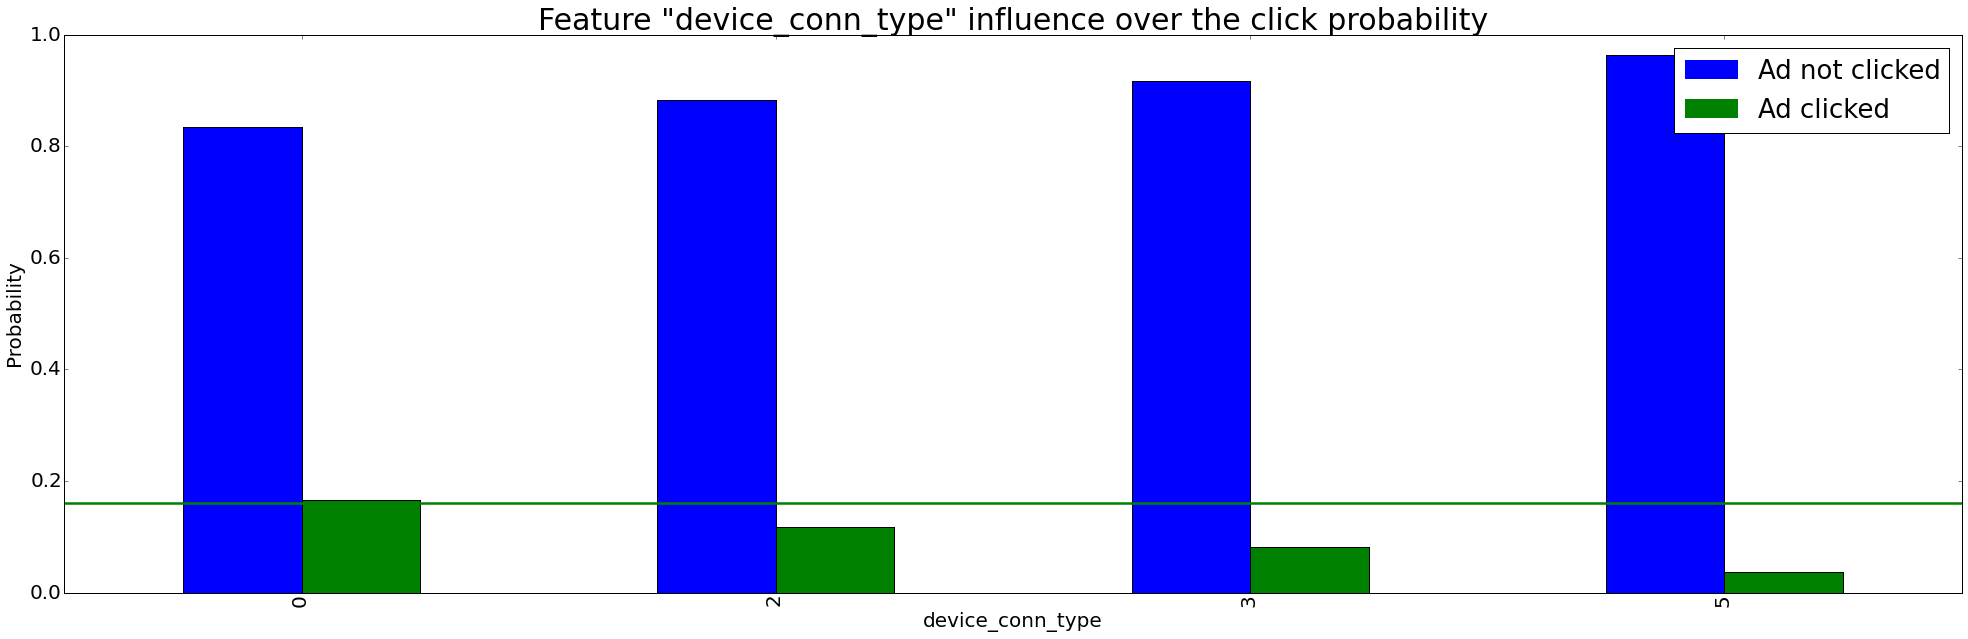

In [276]:
conditional_clicks('device_conn_type',prob)